# Developing a basic Tensorflow framework

## We ll be building the skeleton of Tensorflow framework using just basic python¶

## Important components:

1) Graph : Holds information regarding order of computations

2) Operations: Nodes in the graph

Gradient computations are described in later sections

# Graph

In [107]:
class Graph():
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def set_as_default(self):
        global _default_graph
        _default_graph = self

# Operation

In [108]:
class Operation():
    
    def __init__(self,input_nodes=[]):
            
        self.input_nodes = input_nodes
        self.output_nodes = []
        
        for node in input_nodes:
            #add the current node to the output node of the input nodes passed
            node.output_nodes.append(self)
            
        _default_graph.operations.append(self)
            
    #This is called when executing the graph with Session class
    def compute(self):
        #should be implemented by child class
        pass

In [92]:
class add(Operation):
    def __init__(self,x,y):
        self.name = "add"
        super().__init__([x,y])
        
    def compute(self,x_var,y_var):
        self.inputs = [x_var,y_var]
        return x_var + y_var
        

In [93]:
class multiply(Operation):
    def __init__(self,x,y):
        self.name = "multiply"
        super().__init__([x,y])
        
    def compute(self,x_var,y_var):
        self.inputs = [x_var,y_var]
        return x_var * y_var

In [94]:
class matmul(Operation):
    def __init__(self,x,y):
        self.name = "matmul"
        super().__init__([x,y])
        
    def compute(self,x_var,y_var):
        self.inputs = [x_var,y_var]
        #assuming they are numpy array
        return x_var.dot(y_var)

# Variable
NOTE: In Tensorflow, variables are those nodes in a graph for which gradient have to be computed. But we ll be going into gradient computations in later section

In [95]:
class Variable():
    def __init__(self,name,initial_value=None):
        self.name = name
        self.value = initial_value
        self.output_nodes = []
        _default_graph.variables.append(self)

# Placeholder
These are data inputs

In [96]:
class Placeholder():
    def __init__(self,name):
        self.name = name
        self.output_nodes = []
        _default_graph.variables.append(self)

In [97]:
g = Graph()
g.set_as_default()

In [98]:
A = Variable("A",10)
B = Variable("B",1)
x = Placeholder("x")
y = multiply(A,x)
z = add(y,B)

# Build the order of execution¶

In [99]:
def traverse_postorder(operation):
    
    nodes_postorder = []
    
    def recurse(node):
        if isinstance(node,Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append({node.name : node})
            
    recurse(operation)
    
    return nodes_postorder

In [100]:
tree = traverse_postorder(z)
tree

[{'A': <__main__.Variable at 0x19eb0ac1f08>},
 {'x': <__main__.Placeholder at 0x19eb0ac1f48>},
 {'multiply': <__main__.multiply at 0x19eb0ac1f88>},
 {'B': <__main__.Variable at 0x19eb0ac1ec8>},
 {'add': <__main__.add at 0x19eb0ac1fc8>}]

In [101]:
list(tree[0].values())[0]

# Execute the graph with Session class

In [102]:
class Session():
    
    def run(self,operation,feed_dict={}):
        #Get the order of execution
        nodes_postorder = traverse_postorder(operation)
        
        for node_d in nodes_postorder:
            
            node = list(node_d.values())[0]
            print(node.name)
            
            if isinstance(node,Placeholder):
                #Placeholder node
                node.value = feed_dict[node]
            elif isinstance(node, Operation):
                #Operation node
                node.inputs = [input_node.value for input_node in node.input_nodes]
                #compute
                node.value = node.compute(*node.inputs) 
                #* implies number of params is determined by size of list
                print(node.name, " Inputs :", node.inputs, "Out: ", node.value)
                
                if type(node.value) == list:
                    #for matmul to work
                    node.value = np.array(node.value)
                
        return operation.value

In [103]:
sess = Session()


In [104]:
result = sess.run(z,feed_dict={x:3})

A
x
multiply
multiply  Inputs : [10, 3] Out:  30
B
add
add  Inputs : [30, 1] Out:  31


In [105]:
g = Graph()
g.set_as_default()

In [106]:

A = Variable("A",np.array([[10,20],[30,40]]))
b = Variable("b",np.array([1,2]))
x = Placeholder("x")

z = add(matmul(A,x),b)

In [22]:
sess = Session()
sess.run(z,feed_dict={x:10})

A
x
matmul
matmul  Inputs : [array([[10, 20],
       [30, 40]]), 10] Out:  [[100 200]
 [300 400]]
b
add
add  Inputs : [array([[100, 200],
       [300, 400]]), array([1, 2])] Out:  [[101 202]
 [301 402]]


array([[101, 202],
       [301, 402]])

# Activation Function

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

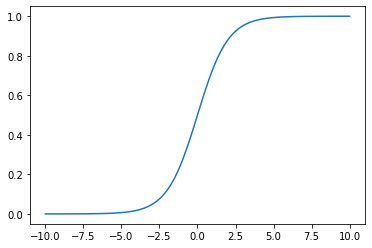

In [25]:
sample_z = np.linspace(-10,10,100)
sample_a = sigmoid(sample_z)
plt.plot(sample_z,sample_a)

## Activation is a type of operation

In [26]:
class Sigmoid(Operation):
    
    def __init__(self,z):
        self.name = "sigmoid"
        super().__init__([z])
        
    def compute(self,z_val):
        return sigmoid(z_val)

## Create random dataset with sklearn

In [27]:
from sklearn.datasets import make_blobs
data = make_blobs(n_samples=50,n_features=2,centers=2,random_state=75) #centers=[number of classes]
data

(array([[  7.3402781 ,   9.36149154],
        [  9.13332743,   8.74906102],
        [  1.99243535,  -8.85885722],
        [  7.38443759,   7.72520389],
        [  7.97613887,   8.80878209],
        [  7.76974352,   9.50899462],
        [  8.3186688 ,  10.1026025 ],
        [  8.79588546,   7.28046702],
        [  9.81270381,   9.46968531],
        [  1.57961049,  -8.17089971],
        [  0.06441546,  -9.04982817],
        [  7.2075117 ,   7.04533624],
        [  9.10704928,   9.0272212 ],
        [  1.82921897,  -9.86956281],
        [  7.85036314,   7.986659  ],
        [  3.04605603,  -7.50486114],
        [  1.85582689,  -6.74473432],
        [  2.88603902,  -8.85261704],
        [ -1.20046211,  -9.55928542],
        [  2.00890845,  -9.78471782],
        [  7.68945113,   9.01706723],
        [  6.42356167,   8.33356412],
        [  8.15467319,   7.87489634],
        [  1.92000795,  -7.50953708],
        [  1.90073973,  -7.24386675],
        [  7.7605855 ,   7.05124418],
        [  6

In [28]:
features = data[0]
labels = data[1]

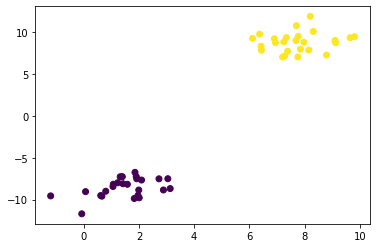

In [29]:
#plt.plot(features[:,0],features[:,1],'r*') #also works the same except we dont have option to color acc to labels
plt.scatter(features[:,0],features[:,1],c=labels) 

## Handcoded classifier

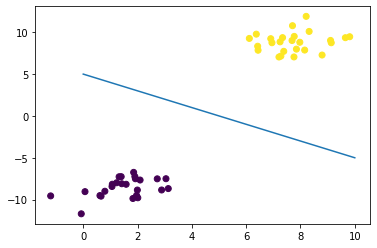

In [30]:
x = np.linspace(0,10,10)
y = -x+5
plt.scatter(features[:,0],features[:,1],c=labels) 
plt.plot(x,y)

In [31]:
res = np.array([1,1]).dot(np.array([[8],[10]])) - 5
print(res)
print(sigmoid(res))

[13]
[0.99999774]


## We build a graph for this classifier

In [32]:
g = Graph()
g.set_as_default()
F = Placeholder("F")
W = Variable("W",np.array([1,1]))
b = Variable("b",-5)
z = add(matmul(W,F),b)
a = Sigmoid(z)

## This point belongs to yellow class

In [33]:
sess = Session()


sess.run(a,feed_dict={F:np.array([8,10])})

W
F
matmul
matmul  Inputs : [array([1, 1]), array([ 8, 10])] Out:  18
b
add
add  Inputs : [18, -5] Out:  13
sigmoid
sigmoid  Inputs : [13] Out:  0.999997739675702


0.999997739675702

In [34]:
traverse_postorder(a)

[{'W': <__main__.Variable at 0x19eac98a588>},
 {'F': <__main__.Placeholder at 0x19eb09cb488>},
 {'matmul': <__main__.matmul at 0x19eb09cb248>},
 {'b': <__main__.Variable at 0x19eb09cb208>},
 {'add': <__main__.add at 0x19eb09cb388>},
 {'sigmoid': <__main__.Sigmoid at 0x19eb09cb308>}]

In [35]:
sess.run(a,feed_dict={F:np.array([0,-5])})

W
F
matmul
matmul  Inputs : [array([1, 1]), array([ 0, -5])] Out:  -5
b
add
add  Inputs : [-5, -5] Out:  -10
sigmoid
sigmoid  Inputs : [-10] Out:  4.5397868702434395e-05


4.5397868702434395e-05